# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
import re
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense,
                                     LayerNormalization, Dropout,
                                     GlobalAveragePooling2D, Bidirectional,
                                     LSTM, Lambda, GlobalMaxPool1D, GlobalMaxPooling1D, Flatten, Input)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.layers import Layer
from keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.losses import categorical_crossentropy
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-17 21:19:59--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-17 21:19:59 (86.2 MB/s) - ‘helper_functions.py’ saved [7752/7752]



In [3]:
from helper_functions import (make_confusion_matrix, plot_loss_curves, calculate_results, plot_class_accuracy,
                              plot_prediction_confidence_histogram, create_tensorboard_callback)

# Data Downloading

In [17]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d amananandrai/ag-news-classification-dataset
! unzip "/content/ag-news-classification-dataset.zip" -d "/content/dataset/"

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 88% 10.0M/11.4M [00:01<00:00, 12.2MB/s]
100% 11.4M/11.4M [00:01<00:00, 7.55MB/s]
Archive:  /content/ag-news-classification-dataset.zip
  inflating: /content/dataset/test.csv  
  inflating: /content/dataset/train.csv  


# Data Loading

In [18]:
df = pd.read_csv("/content/dataset/train.csv")

In [19]:
df.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

In [20]:
df.duplicated().sum()

0

In [21]:
df.drop_duplicates(inplace=True)

In [22]:
df['Class Index'].value_counts()

3    30000
4    30000
2    30000
1    30000
Name: Class Index, dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [24]:
df.head(5)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [25]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', ' ', text) # Remove URL from string
    text = re.sub('<.*?>+', ' ', text) # Remove HTML Tags
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # Replace Punctuation with space
    text = re.sub('\n', ' ', text) # Replace NewLine with space
    text = re.sub(r'\w*\d\w*', ' ', text) # Remove alphanumeric
    text = text.replace('-', ' ')
    text = ' '.join(text.split())  # Strip extra spaces
    return text

In [26]:
clean_text("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this ** ?????? ?movie! would you?<br> <br /><br />T")

'in the movie man called tévèz went to a friend’s pl ce and they had a tensed discussion i don’t love this movie would you t'

In [27]:
df['Title'] = df['Title'].apply(clean_text)

In [28]:
max_value = 120000
random_number = np.random.randint(0, max_value)
sample_row = df.iloc[random_number, :].values
sample_title, sample_label  = sample_row[0], sample_row[1]

In [29]:
first_text = []
second_text = []
labels = []
max_value = 120000

for index, row in df.iterrows():
    label = row['Class Index']
    title = row['Title']
    first_text.append(title)
    labels.append(label)

    while True:
      random_number = np.random.randint(0, max_value)
      sample_row = df.iloc[random_number, :].values
      sample_label, sample_title  = sample_row[0], sample_row[1]
      if sample_label == label:
          break

    second_text.append(sample_title)

In [ ]:
new_df = pd.DataFrame(list(zip(first_text, second_text, labels)), columns =['first_text', 'second_text', 'labels'])
new_df.head(5)

In [30]:
for first, second, label in zip(first_text[:5], second_text[:5], labels[:5]):
    print(first, "|", second, "|", label)

wall st bears claw back into the black reuters | boj keeps easy monetary policy sees slight inflation next year afp | 3
carlyle looks toward commercial aerospace reuters | city has good reason to keep faith in morrison | 3
oil and economy cloud stocks outlook reuters | merck pulls vioxx | 3
iraq halts oil exports from main southern pipeline reuters | ceos see more hiring capital spending | 3
oil prices soar to all time record posing new menace to us economy afp | chip sales rise inventories seen down reuters | 3


In [31]:
text_length = [len(sentence.split()) for sentence in first_text]
avg_text_length = np.mean(text_length)
print(avg_text_length)

6.85375


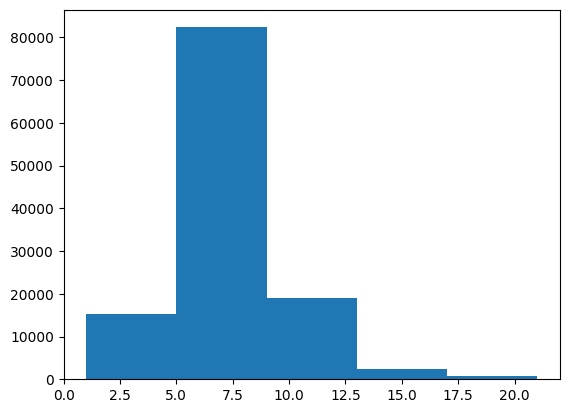

In [32]:
plt.hist(text_length, bins=5);

In [33]:
output_text_length = int(np.percentile(text_length, 95))
print(output_text_length)

11


# Sentence tokenization and embeddings

In [34]:
max_tokens = 30000
vectorize_layer = TextVectorization(max_tokens = max_tokens,
                                    output_mode = 'int',
                                    standardize = 'lower_and_strip_punctuation',
                                    output_sequence_length = 11)

vectorize_layer.adapt(first_text)

In [35]:
random_sentence = random.choice(first_text)
print('Sentence:', random_sentence)
print('Length of sentence:', len(random_sentence.split()))
print('Vectorized_Form:', vectorize_layer([random_sentence]))

Sentence: galloway wins libel case
Length of sentence: 4
Vectorized_Form: tf.Tensor([[9083   51 6367  134    0    0    0    0    0    0    0]], shape=(1, 11), dtype=int64)


In [36]:
text_vocab = vectorize_layer.get_vocabulary()
print("Total number of words in vocalbuary", len(text_vocab))
print("The Top Most 5 common words in vocalbuary:", text_vocab[:5])
print("The Least Most 5 common words in vocalbuary:", text_vocab[-5:])

Total number of words in vocalbuary 30000
The Top Most 5 common words in vocalbuary: ['', '[UNK]', 'to', 'in', 'for']
The Least Most 5 common words in vocalbuary: ['creatures', 'creatini', 'creamer', 'creamed', 'creaks']


In [37]:
vectorize_layer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 30000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 11,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 30000}

# Label Encoding

In [38]:
labels = np.array(labels)

In [39]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [40]:
class_labels = label_encoder.classes_.tolist()
print("Labels in dataset are:", class_labels)

Labels in dataset are: [1, 2, 3, 4]


In [41]:
num_classes = 4
labels_one_hot = to_categorical(labels, num_classes=num_classes)

In [42]:
first_text_data = tf.data.Dataset.from_tensor_slices(first_text)
second_text_data = tf.data.Dataset.from_tensor_slices(second_text)
label_data = tf.data.Dataset.from_tensor_slices(labels_one_hot)

dataset = tf.data.Dataset.zip(({'first_text': first_text_data, 'second_text': second_text_data}, label_data))

In [43]:
for inputs, outputs in dataset.take(1):
  first_text, second_text = inputs['first_text'], inputs['second_text']
  print(first_text)
  print(second_text)
  print(outputs)

tf.Tensor(b'wall st bears claw back into the black reuters', shape=(), dtype=string)
tf.Tensor(b'boj keeps easy monetary policy sees slight inflation next year afp', shape=(), dtype=string)
tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)


In [44]:
labels = df['Class Index'].value_counts().index
values = df['Class Index'].value_counts().values
total_datapoints = 120000
weights = {}
for label, value in zip(labels, values):
  weights[class_labels.index(label)] = total_datapoints / value

print("Class Weights:", weights)

Class Weights: {2: 4.0, 3: 4.0, 1: 4.0, 0: 4.0}


## Data Loading

In [45]:
dataset = (
    dataset
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [46]:
dataset

<_PrefetchDataset element_spec=({'first_text': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'second_text': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

# Model

In [47]:

def positional_encoding(model_size, SEQUENCE_LENGTH):
  output = []
  for pos in range(SEQUENCE_LENGTH):
    PE = np.zeros((model_size))
    for i in range(model_size):
      if i%2 == 0:
        PE[i] = np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i] = np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE, axis=0))
  out = tf.concat(output, axis=0)
  out = tf.expand_dims(out, axis=0)
  return tf.cast(out, dtype=tf.float32)

In [48]:
positional_encoding(256, 14).shape

TensorShape([1, 14, 256])

In [49]:
@tf.keras.utils.register_keras_serializable()
class Embeddings(Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
    super(Embeddings, self).__init__(**kwargs)
    self.token_embeddings = Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = positional_encoding(self.embed_dim, self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

  def get_config(self):
    config = super(Embeddings, self).get_config()
    config.update({
        'sequence_length': self.sequence_length,
        'vocab_size': self.vocab_size,
        'embed_dim': self.embed_dim,
    })
    return config

In [50]:
@tf.keras.utils.register_keras_serializable()
class Encoder(Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super(Encoder, self).__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
    self.dense_proj = tf.keras.Sequential(
        [Dense(dense_dim, activation='relu'),
         Dense(embed_dim)])
    self.layernorm_1 = LayerNormalization()
    self.layernorm_2 = LayerNormalization()
    self.supports_masking = True

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

  def call(self, inputs, mask=None):
    if mask is not None:
      mask1 = mask[:, :, tf.newaxis]
      mask2 = mask[:, tf.newaxis, :]
      padding_mask = tf.cast(mask1 & mask2, dtype="int32")

    attention_output = self.attention(query=inputs, key=inputs, value=inputs, attention_mask=padding_mask)
    proj_input = self.layernorm_1(inputs + attention_output)
    proj_output = self.dense_proj(proj_input)
    return self.layernorm_2(proj_input + proj_output)

  def get_config(self):
    config = super(Encoder, self).get_config()
    config.update({
        'embed_dim': self.embed_dim,
        'num_heads': self.num_heads,
        'dense_dim': self.dense_dim,
    })
    return config

In [51]:
num_layers = 1
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.4
vocab_size = 30000
sequence_len = 11

In [53]:
input_layer = Input(shape=[], dtype="string", name="input")
x = vectorize_layer(input_layer)
x = Embeddings(sequence_len, vocab_size, d_model)(x)
for _ in range(num_layers):
  x = Encoder(d_model, dff, num_heads)(x)
x = Dropout(rate=0.4)(x)
x = Flatten()(x)
output_layer = Dense(512, activation="relu")(x)

transformer = Model(input_layer, output_layer, name="transformer")
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None,)]                 0         
                                                                 
 text_vectorization (TextVe  (None, 11)                0         
 ctorization)                                                    
                                                                 
 embeddings (Embeddings)     (None, 11, 128)           3840000   
                                                                 
 encoder (Encoder)           (None, 11, 128)           659712    
                                                                 
 dropout (Dropout)           (None, 11, 128)           0         
                                                                 
 flatten (Flatten)           (None, 1408)              0         
                                                       

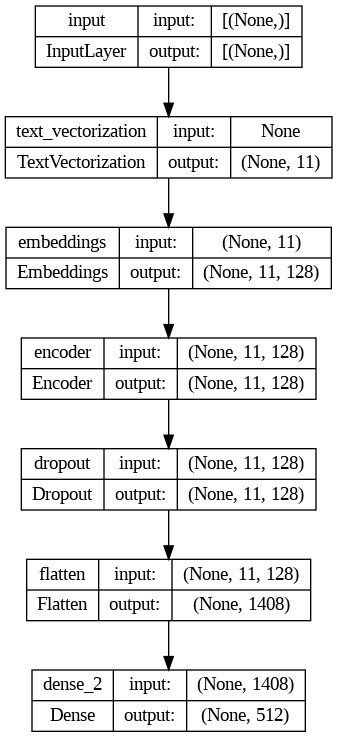

In [54]:
plot_model(transformer, show_shapes=True)

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization
from tensorflow.keras.metrics import Mean

In [56]:
@tf.keras.utils.register_keras_serializable()
class SiameseNetwork(tf.keras.Model):
    def __init__(self, model):
        super(SiameseNetwork, self).__init__()
        self.model = model
        self.dense = Dense(units=4, activation='softmax')
        self.layer_norm = LayerNormalization()

    def compile(self, optimizer, loss_fn):
        super(SiameseNetwork, self).compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_metric = Mean(name='loss')

    def call(self, inputs):
        return self.model(inputs)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, train_data):
        inputs, labels = train_data
        first_text, second_text = inputs['first_text'], inputs['second_text']

        with tf.GradientTape() as tape:
            first_text_embed = self.model(first_text)
            second_text_embed = self.model(second_text)
            merge_layer = tf.concat([first_text_embed, second_text_embed, tf.abs(first_text_embed - second_text_embed)], axis=-1)
            # normalized_layer = self.layer_norm(merge_layer)
            output_layer = self.dense(merge_layer)
            loss = self.loss_fn(labels, output_layer)

        partial_derivatives = tape.gradient(loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(partial_derivatives, self.model.trainable_weights))
        self.loss_metric.update_state(loss)

        return {'loss': self.loss_metric.result()}

    def get_config(self):
      config = super(SiameseNetwork, self).get_config()
      config.update({
          'output_dim': 4,
      })
      return config

In [57]:
siamese_model = SiameseNetwork(transformer)

In [58]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
siamese_model.compile(optimizer=optimizer, loss_fn=loss_fn)

In [59]:
history = siamese_model.fit(dataset, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 63s 26ms/step - loss: 0.7648
Epoch 2/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1554
Epoch 3/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0921
Epoch 4/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0612
Epoch 5/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0455
Epoch 6/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0331
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0263
Epoch 8/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0216
Epoch 9/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0180
Epoch 10/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0137


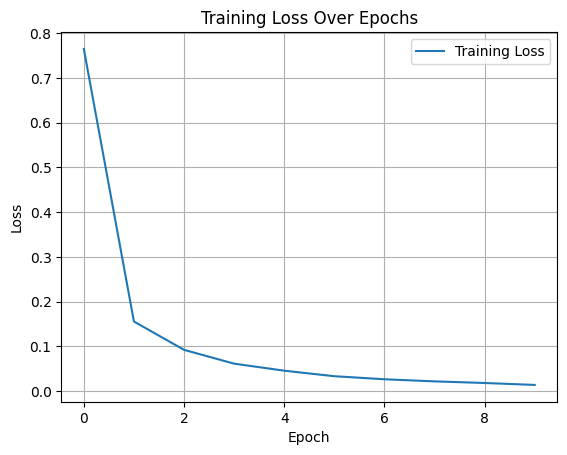

In [60]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
siamese_model.predict(["wall st bears claw back into the black reuters"]).shape

1/1 [==============================] - 0s 454ms/step


(1, 512)

# Sentence Transformer Model

In [ ]:
MAX_LENGTH = 11
BATCH_SIZE = 128

In [ ]:
new_df = pd.DataFrame(list(zip(first_text, second_text, labels)), columns =['first_text', 'second_text', 'labels'])
new_df.head(5)

In [ ]:
dataset = Dataset.from_pandas(new_df)

In [ ]:
dataset

In [ ]:
dataset[0]

In [ ]:
model_id = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
def preprocess(dataset):
  dataset['input_ids_first_text']=[]
  dataset['token_type_ids_first_text']=[]
  dataset['attention_mask_first_text']=[]

  dataset['input_ids_second_text']=[]
  dataset['token_type_ids_second_text']=[]
  dataset['attention_mask_second_text']=[]
  
  tokenized_output_first_text=tokenizer(dataset['first_text'], max_length=MAX_LENGTH, padding='max_length', truncation=True)
  tokenized_output_second_text=tokenizer(dataset['second_text'], max_length=MAX_LENGTH, padding='max_length', truncation=True)
  
  dataset['input_ids_first_text'].append(tokenized_output_first_text['input_ids'])
  dataset['token_type_ids_first_text'].append(tokenized_output_first_text['token_type_ids'])
  dataset['attention_mask_first_text'].append(tokenized_output_first_text['attention_mask'])
  
  dataset['input_ids_second_text'].append(tokenized_output_second_text['input_ids'])
  dataset['token_type_ids_second_text'].append(tokenized_output_second_text['token_type_ids'])
  dataset['attention_mask_second_text'].append(tokenized_output_second_text['attention_mask'])

  dataset['labels'] = dataset['labels']
  
  return dataset

In [ ]:
prep_dataset=dataset.map(preprocess)

In [ ]:
tf_dataset = prep_dataset.to_tf_dataset(
    columns=['input_ids_first_text', 'token_type_ids_first_text', 'attention_mask_first_text','input_ids_second_text', 'token_type_ids_second_text', 'attention_mask_second_text', 'labels'],
    shuffle=True, 
    batch_size=BATCH_SIZE,)

In [ ]:
tf_dataset

In [ ]:
for i in tf_dataset.take(1):
  print(i[0])

In [ ]:
model = TFAutoModel.from_pretrained(model_id)
model.summary()

In [ ]:
@tf.keras.utils.register_keras_serializable()
class SentenceTransformer(tf.keras.Model):
  def __init__(self,model):
    super(SentenceTransformer,self).__init__()
    self.model=model
    self.dense=Dense(4, activation='softmax')

  def compile(self,optimizer,loss_fn):
    super(SentenceTransformer,self).compile()
    self.optimizer=optimizer
    self.loss_fn=loss_fn
    self.loss_metric=tf.keras.metrics.Mean(name='loss')

  @property
  def metrics(self):
    return [self.loss_metric]
  
  def mean_pooling(self, model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = tf.cast(tf.broadcast_to(tf.expand_dims(attention_mask, -1), tf.shape(token_embeddings)),
        tf.float32)
    return tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)/tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
  
  def train_step(self,train_data):
    first_text = {'input_ids':train_data['input_ids_first_text'][:,0,:],
           'token_type_ids':train_data['token_type_ids_first_text'][:,0,:],
           'attention_mask':train_data['attention_mask_first_text'][:,0,:]}

    second_text = {'input_ids':train_data['input_ids_second_text'][:,0,:],
             'token_type_ids':train_data['token_type_ids_second_text'][:,0,:],
             'attention_mask':train_data['attention_mask_second_text'][:,0,:]}

    labels = train_data['label']

    with tf.GradientTape() as recorder:
      first_text_predictions = self.model(first_text)
      pred_first_text = self.mean_pooling(first_text_predictions, train_data['attention_mask_first_text'][:,0,:])
      
      second_text_predictions = self.model(second_text)
      pred_second_text = self.mean_pooling(second_text_predictions,train_data['attention_mask_second_text'][:,0,:])
      
      pred_concat = tf.concat([pred_first_text, pred_second_text, tf.abs(pred_first_text - pred_second_text)],axis=-1)
      
      predictions = self.dense(pred_concat)
      loss=  self.loss_fn(labels, predictions)

    partial_derivatives = recorder.gradient(loss,self.model.trainable_weights)
    self.optimizer.apply_gradients(zip(partial_derivatives, self.model.trainable_weights))
    self.loss_metric.update_state(loss)
    
    return {'loss':self.loss_metric.result(),}

In [ ]:
stransformer = SentenceTransformer(model)
stransformer.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,),
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(),
)

In [ ]:
EPOCHS = 5
history = stransformer.fit(tf_dataset, epochs=EPOCHS,)

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save The Model

In [62]:
siamese_model.save("siamese_model")
loaded_siamese_model = tf.keras.models.load_model("siamese_model")

In [ ]:
loaded_siamese_model.predict(["wall st bears claw back into the black reuters"]).shape

1/1 [==============================] - 0s 90ms/step


(1, 512)

In [ ]:
!cp '/content/siamese_model' '/content/drive/MyDrive/Search_Engine/'

# Saving Embeddings

In [ ]:
def mean_pooling(model_output, attention_mask):
  token_embeddings = model_output[0]
  
  input_mask_expanded = tf.cast(
      tf.broadcast_to(tf.expand_dims(attention_mask, -1), tf.shape(token_embeddings)),
      tf.float32)
  return tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)/tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)

In [ ]:
news_headlines = [title for title in df['Title']]

In [ ]:
INFERENCE_BATCH_SIZE = 640
len(news_headlines)//INFERENCE_BATCH_SIZE

In [ ]:
news_embeddings = []
for i in range(len(product_titles)//INFERENCE_BATCH_SIZE):
  tokenized_output = tokenizer(
      news_headlines[INFERENCE_BATCH_SIZE*i:INFERENCE_BATCH_SIZE*(i+1)], max_length=MAX_LENGTH,padding='max_length',truncation=True,return_tensors="tf")
  model_output=model(tokenized_output)
  embedding=mean_pooling(model_output,tokenized_output['attention_mask'])
  embeddings.append(embedding)
  if i%100==0:
    print(i)    

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 14s 14s/step


In [ ]:
np.savez_compressed('news_headlines.npz', news_headlines)
np.savez_compressed('news_embeddings.npz', news_embeddings)

1/1 [==============================] - 0s 93ms/step


In [ ]:
!cp '/content/news_headlines.npz' '/content/drive/MyDrive/Search_Engine'
!cp '/content/news_embeddings.npz' '/content/drive/MyDrive/Search_Engine'

In [ ]:
news_headlines = np.load('/content/drive/MyDrive/Search_Engine/news_headlines.npz')
loaded_news_headlines = np.array(news_headlines['arr_0'])

news_embeddings = np.load('/content/drive/MyDrive/Search_Engine/news_embeddings.npz')
loaded_news_embeddings = np.array(news_embeddings['arr_0'])

AttributeError: ignored

In [ ]:
loaded_news_embeddings.shape

In [ ]:
loaded_news_embeddings_array = loaded_news_embeddings.reshape(-1, loaded_news_embeddings.shape[2])

In [ ]:
print(loaded_news_embeddings_array.shape)

In [ ]:
headline = "Sun Alliance to move 1100 jobs to India"
tokenizer = AutoTokenizer.from_pretrained(model_id)
inputs = tokenizer([headline], max_length=MAX_LENGTH, padding='max_length', truncation=True, return_tensors="tf")
logits = loaded_model(**inputs)
embeddings = mean_pooling(logits, inputs['attention_mask'])

In [ ]:
embeddings.shape

In [ ]:
u_dot_v = np.matmul(news_embeddings, (np.array(embeddings).T))
print(u_dot_v.shape)

In [ ]:
u_magnitude = np.sqrt(np.sum(news_embeddings * news_embeddings, axis=-1))
print(u_magnitude.shape)
print(u_magnitude)

In [ ]:
v_magnitude=np.sqrt(np.sum(embeddings * embeddings,axis=-1))
print(v_magnitude.shape)
print(v_magnitude)

In [ ]:
cosine_similarity=u_dot_v.T/(u_magnitude * v_magnitude)
print(cosine_similarity)

In [ ]:
sorted_indices=np.argsort(cosine_similarity,axis=-1)
print(sorted_indices)

In [ ]:
for i in range(25):
  print(i, news_headlines[sorted_indices[:,len(sorted_indices[0])-i-1]])

# Hugging Face

In [ ]:
! pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model = tf.keras.models.load_model("siamese_model")

In [ ]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = model, repo_id = "DriveMyScream/Siamese_Neural_Network")

In [ ]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/Siamese_Neural_Network")

In [ ]:
model_id="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
headline = "Sun Alliance to move 1100 jobs to India"
tokenizer = AutoTokenizer.from_pretrained(model_id)
inputs = tokenizer([headline], max_length=MAX_LENGTH, padding='max_length', truncation=True, return_tensors="tf")
logits = loaded_model(**inputs)
embeddings = mean_pooling(logits, inputs['attention_mask'])

# Tensorflow Lite

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("siamese_model")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Siamese_Neural_Network.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


In [ ]:
model_path = "/content/Siamese_Neural_Network.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
output_details

[{'name': 'Identity',
  'index': 177,
  'shape': array([  1, 512], dtype=int32),
  'shape_signature': array([ -1, 512], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
text = ["wall st bears claw back into the black reuters"]
input_data = np.array(text, dtype=np.bytes_)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

RuntimeError: ignored

# Model at inference

In [ ]:
news_headlines = np.load('/content/drive/MyDrive/Siamese_network_Project/news_headlines.npz')
loaded_news_headlines = np.array(news_headlines['arr_0'])

news_embeddings = np.load('/content/drive/MyDrive/Siamese_network_Project/news_embeddings.npz')
loaded_news_embeddings = np.array(news_embeddings['arr_0'])

loaded_model = tf.keras.models.load_model("siamese_model")
model_id="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
headline = "Sun Alliance to move 1100 jobs to India"
tokenizer = AutoTokenizer.from_pretrained(model_id)

def search(query):
  inputs = tokenizer([query], max_length=MAX_LENGTH, padding='max_length', truncation=True, return_tensors="tf")
  logits = loaded_model(**inputs)
  embeddings = mean_pooling(logits, inputs['attention_mask'])
  u_dot_v = np.matmul(news_embeddings,(np.array(embeddings).T))
  u_magnitude = np.sqrt(np.sum(news_embeddings * news_embeddings, axis=-1))
  v_magnitude = np.sqrt(np.sum(embeddings * embeddings, axis=-1))
  cosine_similarity = u_dot_v.T/(u_magnitude * v_magnitude)
  sorted_indices = np.argsort(cosine_similarity, axis=-1)
  for i in range(25):
    print(i, news_headlines[sorted_indices[:,len(sorted_indices[0])-i-1]])